# References

- [**Original tutorial on YouTube**](https://www.youtube.com/watch?v=BrsocJb-fAo)
- [**Original notebook on GitHub**](https://github.com/svpino/youtube-rag/blob/main/rag.ipynb)

# Setup

In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [5]:
YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=cdiD-9MMpb0"

# First Simple Chain

## LLM Model

In [6]:
from langchain_openai.chat_models import ChatOpenAI

In [9]:
# OPENAI_API_KEY is automatically sourced
model = ChatOpenAI(model="gpt-3.5-turbo")

In [10]:
# Example of query
model.invoke("What MLB team won the World Series during the COVID-19 pandemic?")

AIMessage(content='The Los Angeles Dodgers won the World Series during the COVID-19 pandemic in 2020. They defeated the Tampa Bay Rays in a six-game series to claim their first championship since 1988.', response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 21, 'total_tokens': 61}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d052d652-eb58-4ec1-8105-d362f9d4baa6-0', usage_metadata={'input_tokens': 21, 'output_tokens': 40, 'total_tokens': 61})

## Output Parser

The result from the model is an `AIMessage` instance containing the answer. We can extract this answer by chaining the model with an [**output parser**](https://python.langchain.com/docs/modules/model_io/output_parsers/).

Here is what chaining the model with an output parser looks like:
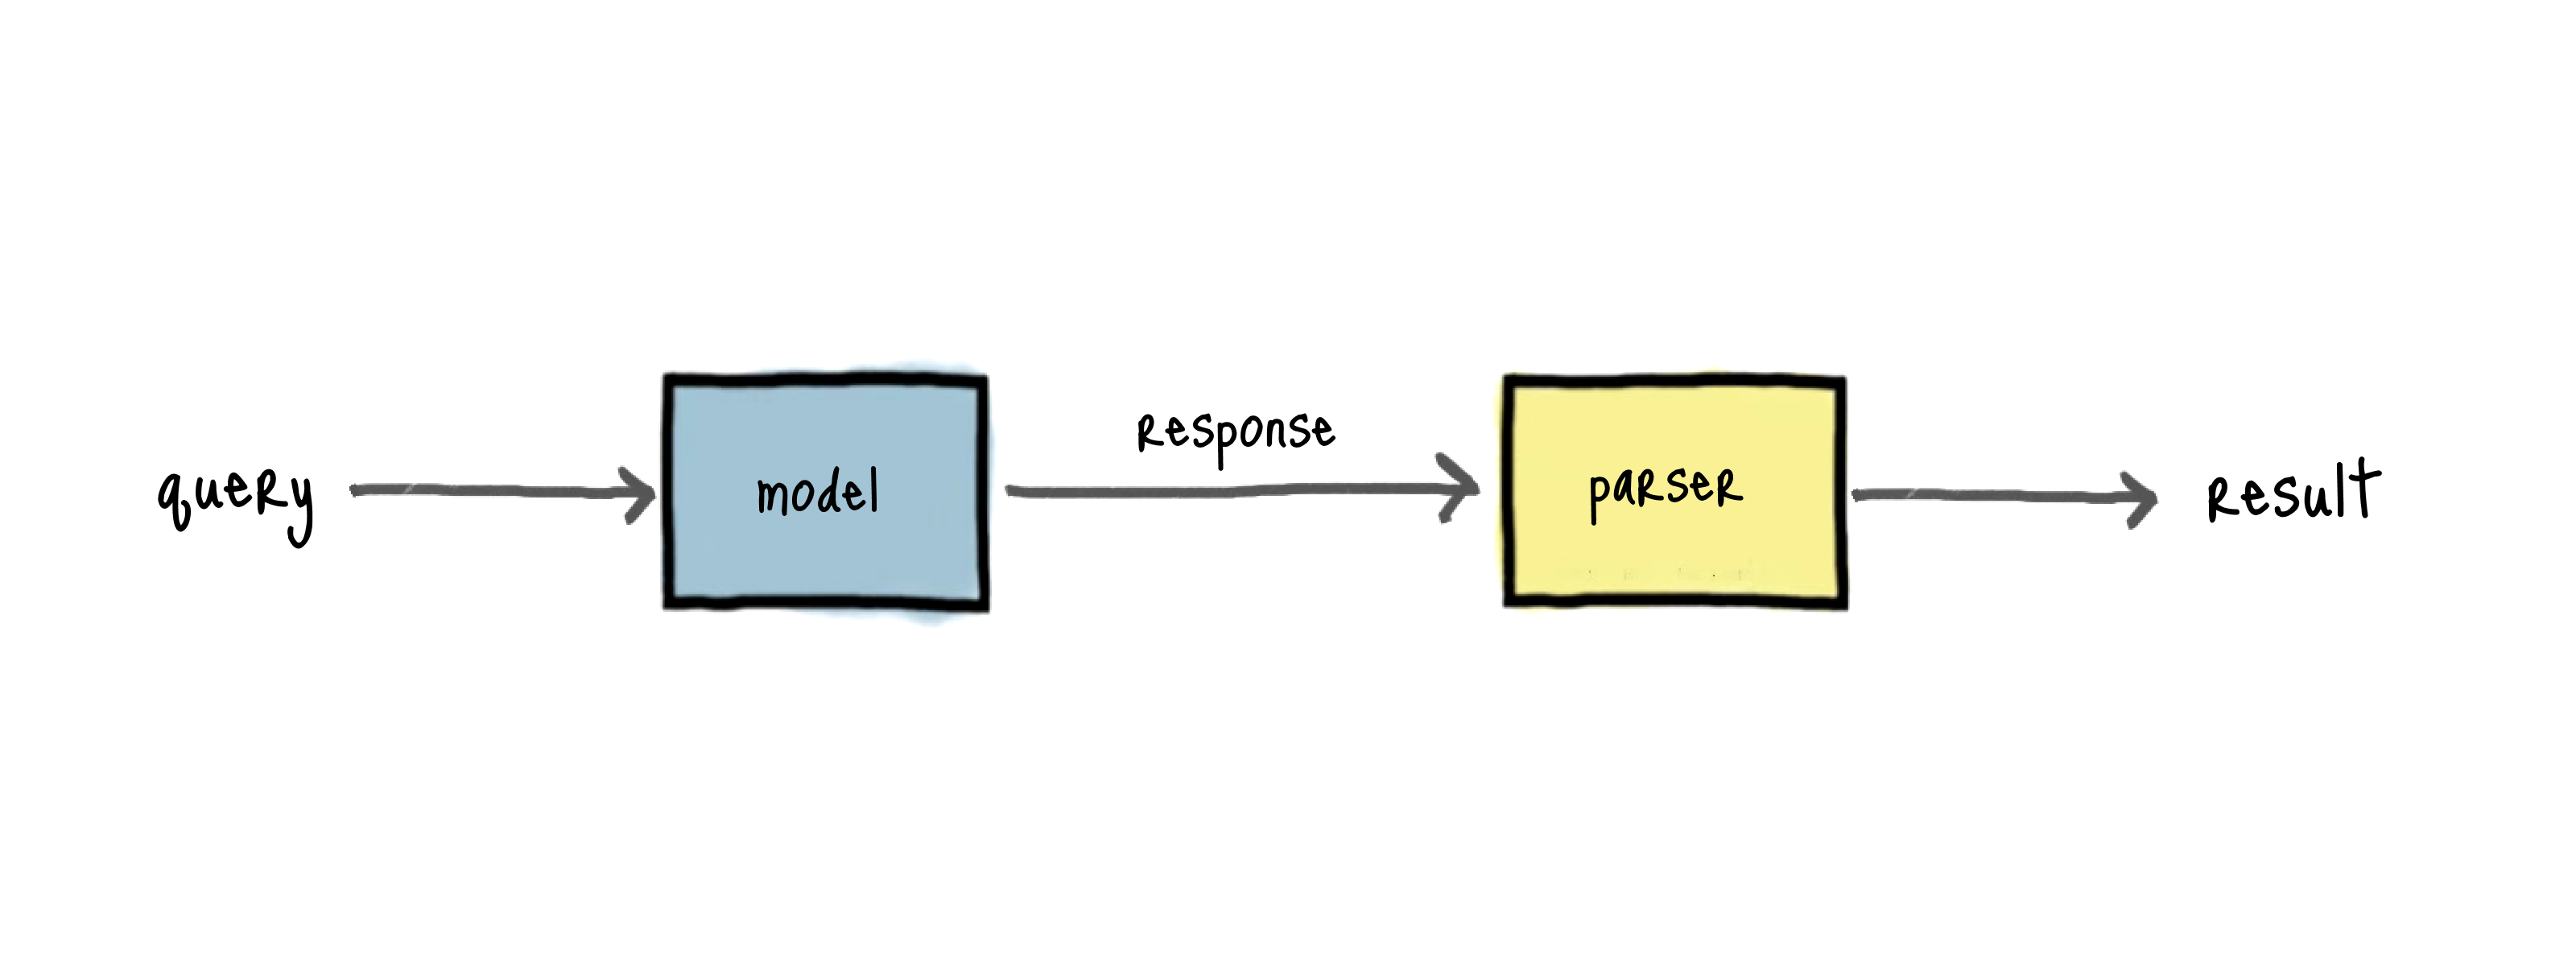

For this example, we'll use a simple `StrOutputParser` to extract the answer as a string.

In [19]:
from langchain_core.output_parsers import StrOutputParser

In [20]:
parser = StrOutputParser()

chain = model | parser

In [21]:
chain

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x784fccf19330>, openai_api_key=SecretStr('**********'), openai_proxy='')
| StrOutputParser()

In [22]:
chain.invoke("What MLB team won the World Series during the COVID-19 pandemic?")

'The Los Angeles Dodgers won the World Series during the COVID-19 pandemic, defeating the Tampa Bay Rays in six games in October 2020.'

## Chat Prompt Template

In [11]:
from langchain.prompts import ChatPromptTemplate

In [14]:
template = """
Answer the question based on the context below. If you can't \
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

In [16]:
print(template)


Answer the question based on the context below. If you can't answer the question, reply "I don't know".

Context: {context}

Question: {question}



In [17]:
prompt = ChatPromptTemplate.from_template(template)
prompt.format(context="Mary's sister is Susana.", question="Who is Mary's sister?")

'Human: \nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: Mary\'s sister is Susana.\n\nQuestion: Who is Mary\'s sister?\n'

We can now chain the prompt with the model and the output parser.
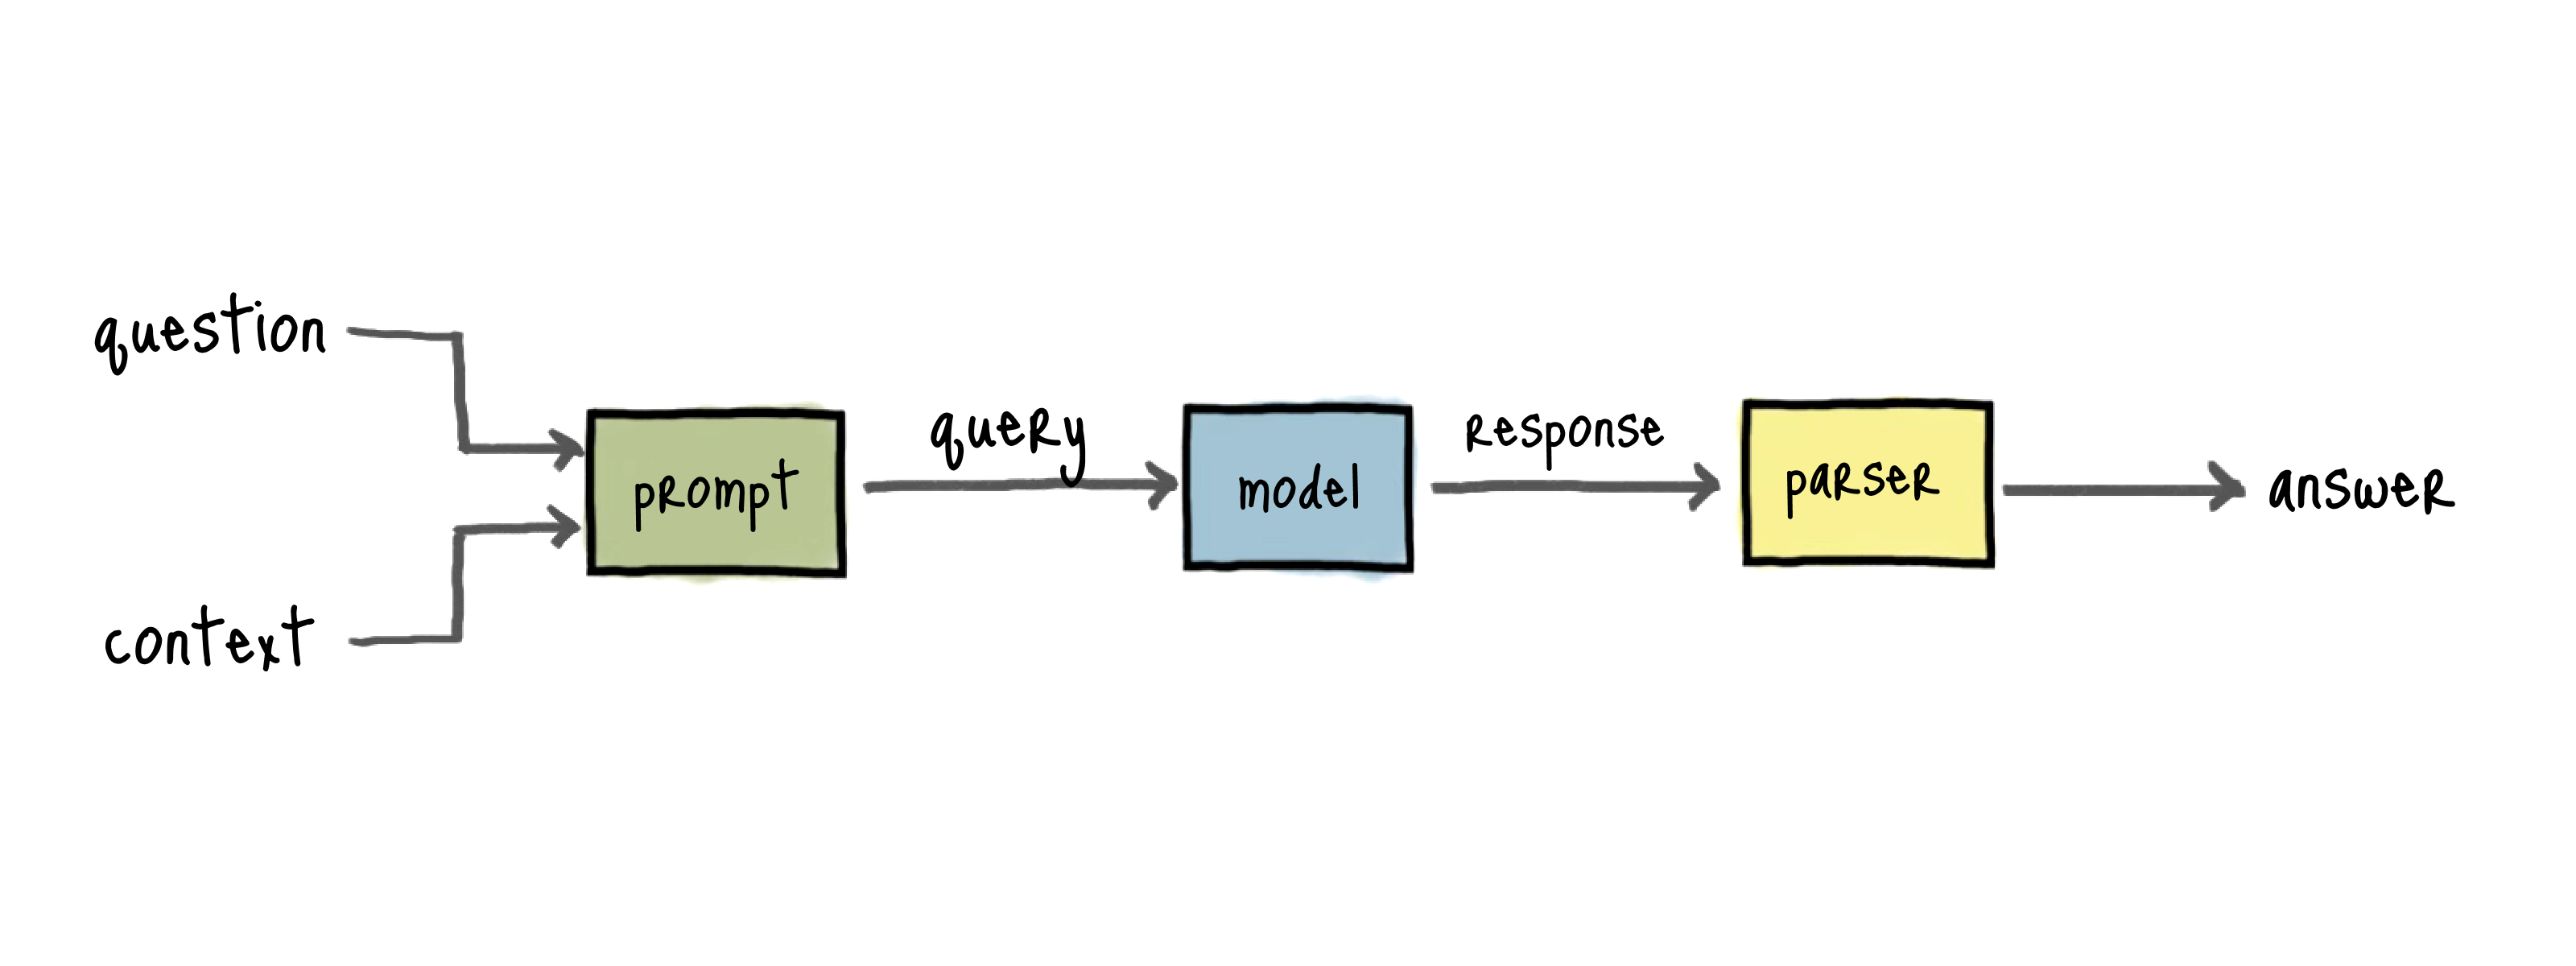

In [23]:
chain = prompt | model | parser

In [24]:
chain

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: {context}\n\nQuestion: {question}\n'))])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x784fccf19330>, openai_api_key=SecretStr('**********'), openai_proxy='')
| StrOutputParser()

In [25]:
chain.invoke({
    "context": "Mary's sister is Susana",
    "question": "Who is Mary's sister?"
})

'Susana'

# Combining Chains

We can **combine different chains to create more complex workflows**. 

For example, let's create a second chain that translates the answer from the first chain into a different language.

In [26]:
translation_prompt = ChatPromptTemplate.from_template(
    "Translate {answer} to {language}"
)

We can now create a new translation chain that combines:
- the result from the first chain,
- the translation prompt

Here's what the new workflow looks like:
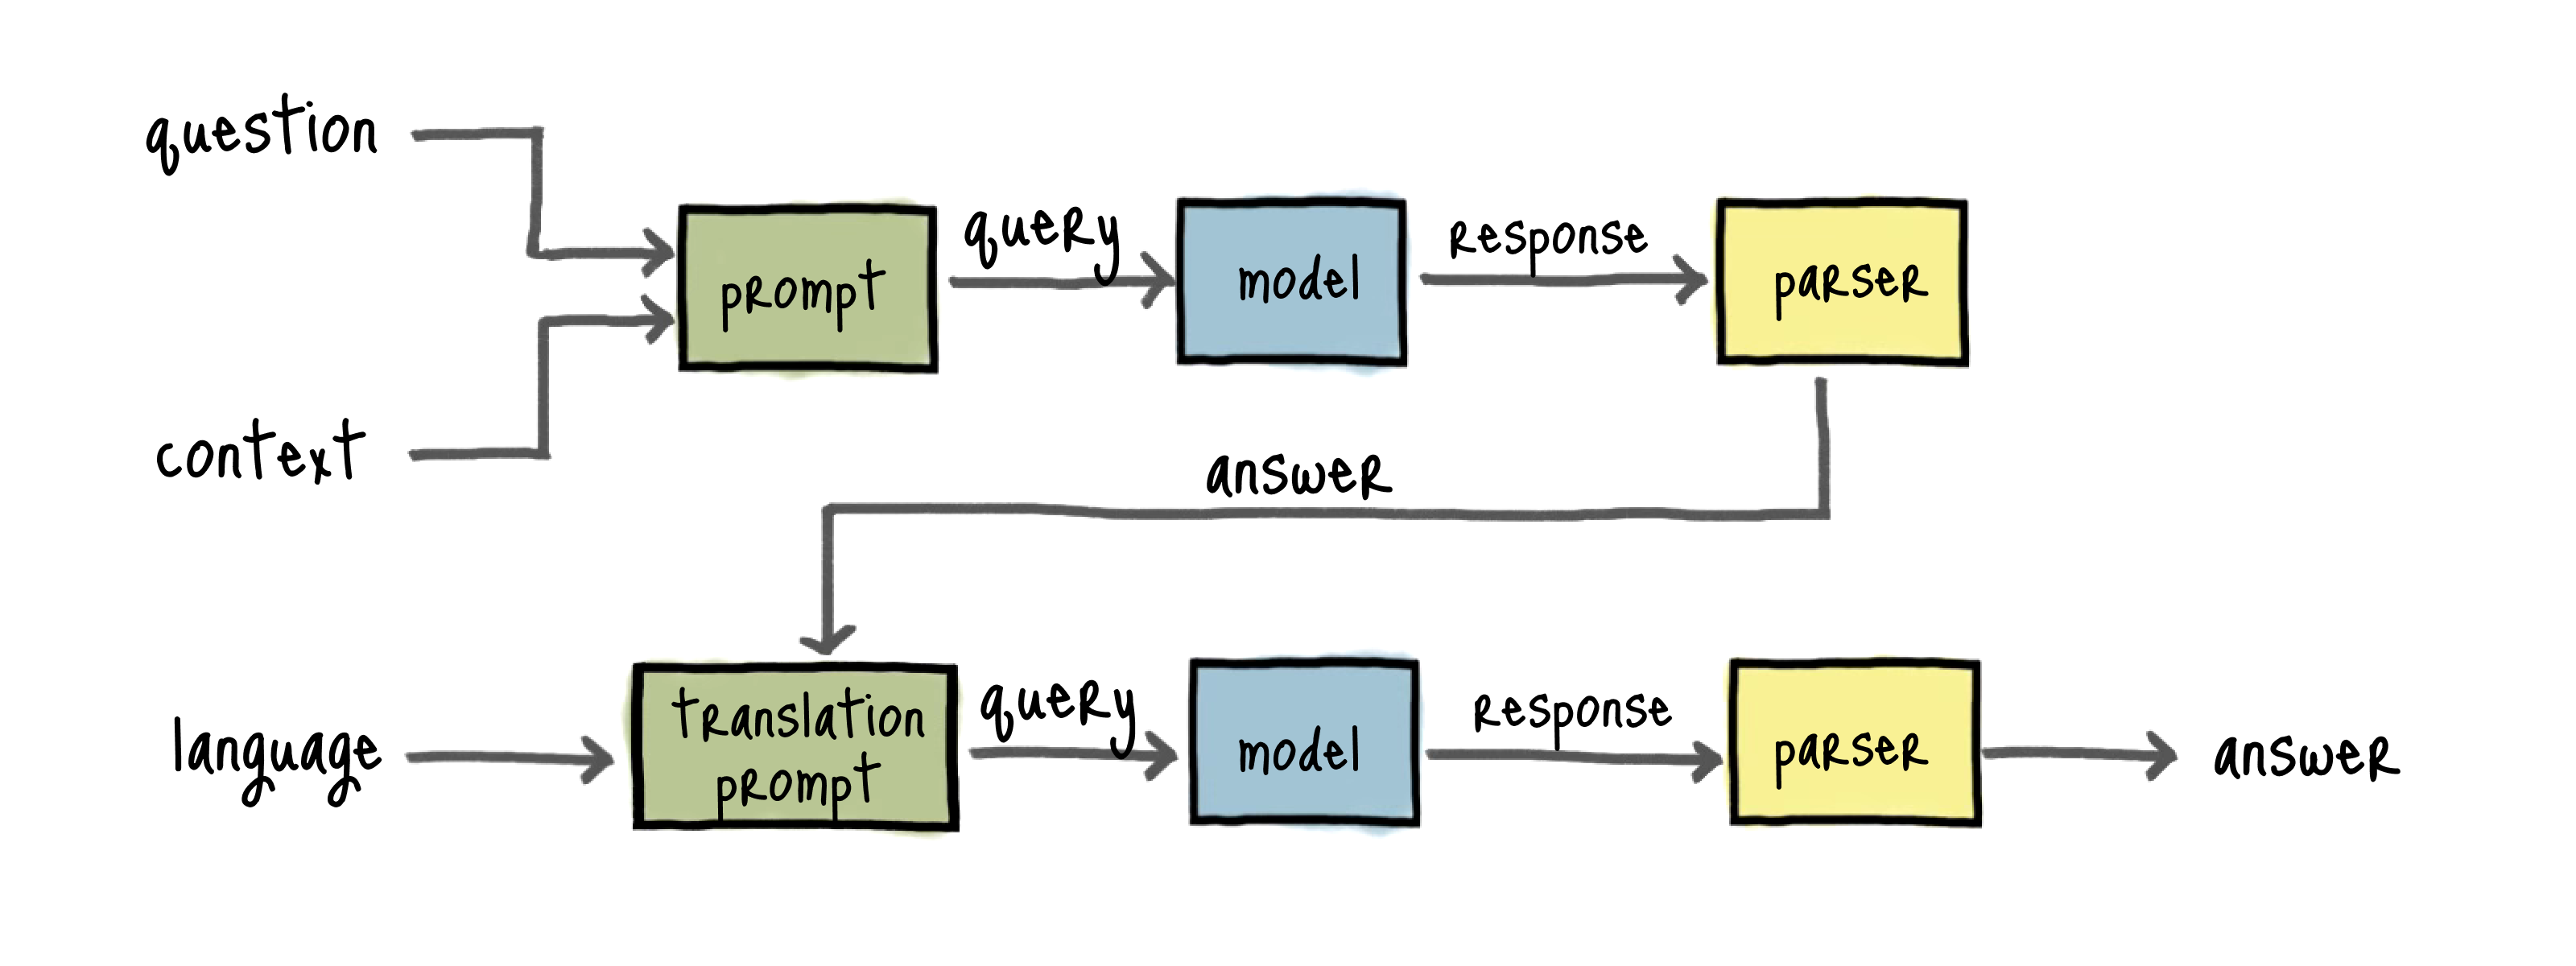
This graph will help us build the full chain.

In [27]:
from operator import itemgetter

In [28]:
translation_chain = (
    {"answer": chain, "language": itemgetter("language")}
    | translation_prompt
    | model
    | parser
)

In [29]:
translation_chain

{
  answer: ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='\nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: {context}\n\nQuestion: {question}\n'))])
          | ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x784fccf19330>, openai_api_key=SecretStr('**********'), openai_proxy='')
          | StrOutputParser(),
  language: RunnableLambda(itemgetter('language'))
}
| ChatPromptTemplate(input_variables=['answer', 'language'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['answer', 'language'], template='Translate {answer} to {language}'))])
| ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x784fcd0189a0>, async_client=<open

The rather weird `itemgetter` syntax above is only here to specify how to manage inputs within the `invoke` method, letting know that the value for `"language"` is gotten from the `dict` input.

In [30]:
translation_chain.invoke(
    {
        "context": "Mary's sister is Susana. She doesn't have any more siblings.",
        "question": "How many sisters does Mary have?",
        "language": "German",
    }
)

'Mary hat eine Schwester, Susana.'

# Transcribing the YouTube Video

The context we want to send the model comes from a YouTube video.

Let's download the video and transcribe it using [**OpenAI's whisper**](https://openai.com/research/whisper)

In [35]:
import os
import tempfile

from openai import OpenAI
import whisper
from pytube import YouTube

In [37]:
client = OpenAI()

> **IMPORTANT NOTE**
> 
> Unfortunately, the code from the tutorial (even if this one is quite recent) already doesn't work because of `whisper.load_model`

In [ ]:
# # Original code
# if not os.path.exists("transcription.txt"):
#     youtube = YouTube(YOUTUBE_VIDEO)
#     audio = youtube.streams.filter(only_audio=True).first()

#     # Let's load the base model. This is not the most accurate
#     # model but it's fast.
#     whisper_model = whisper.load_model("base")

#     with tempfile.TemporaryDirectory() as tmpdir:
#         file = audio.download(output_path=tmpdir)
#         transcription = whisper_model.transcribe(file, fp16=False)["text"].strip()

#         with open("transcription.txt", "w") as file:
#             file.write(transcription)

> **NOTE**
> 
> Tried then to call `whisper` via OpenAI client.
> 
> This doesn't work either, because of this error:
> `Maximum content size limit (26214400) exceeded (26417166 bytes read)`

In [64]:
# # Eventually, translate it to pathlib.Path
# if not os.path.exists("transcription.txt"):
#     youtube = YouTube(YOUTUBE_VIDEO)
#     audio = youtube.streams.filter(only_audio=True).first()

#     with tempfile.TemporaryDirectory() as tmpdir:
#         audio_file = audio.download(output_path=tmpdir)
#         with open(audio_file, "rb") as read_file:
#             transcription = client.audio.transcriptions.create(
#                 model = "whisper-1",
#                 file = read_file
#             )["text"].strip()

#         with open("transcription.txt", "w") as write_file:
#             write_file.write(transcription)



> **NOTE**
>
> Here's one solution, with LangChain's `YoutubeLoader`
> 
> **Next time, I should implement some "auto-detection" for video's id**.

In [45]:
from langchain_community.document_loaders import YoutubeLoader

In [66]:
# Eventually, translate it to pathlib.Path
if not os.path.exists("transcription.txt"):
    with tempfile.TemporaryDirectory() as tmpdir:
        transcript_loader = YoutubeLoader(video_id="cdiD-9MMpb0")
        transcription = transcript_loader.load()[0].page_content
        # Checking documents' length
        print(len(transcription))

        with open("transcription.txt", "w") as write_file:
            write_file.write(transcription)

> **NOTE**
> 
> I wanted to stick to the demo but am wondering if this is still relevant to use a `.txt` file.
> 
> Maybe we could pipe all the steps directly without needing this. I'll explore that.

# Using the Entire Transcription as Context

If we try to invoke the chain using the transcription as context, the model will return an error, because **the context is too long**.

Indeed, LLMs support limited context sizes, and the video we're using is too long for the model to handle, which is illustrated below.

In [67]:
with open("transcription.txt") as file:
    transcription = file.read()

transcription[:100]

"think it's possible that physics has exploits and we should be trying to find them arranging some ki"

In [68]:
try:
    chain.invoke({
        "context": transcription,
        "question": "Is reading papers a good idea?"
    })
except Exception as e:
    print(e)

Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 43795 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


# Splitting the Transcription

Since we can't use the entire transcription as the context for the model, a potential solution is to **split the transcription into smaller chunks**. 

We can then invoke the model **using only the relevant chunks to answer a particular question**:
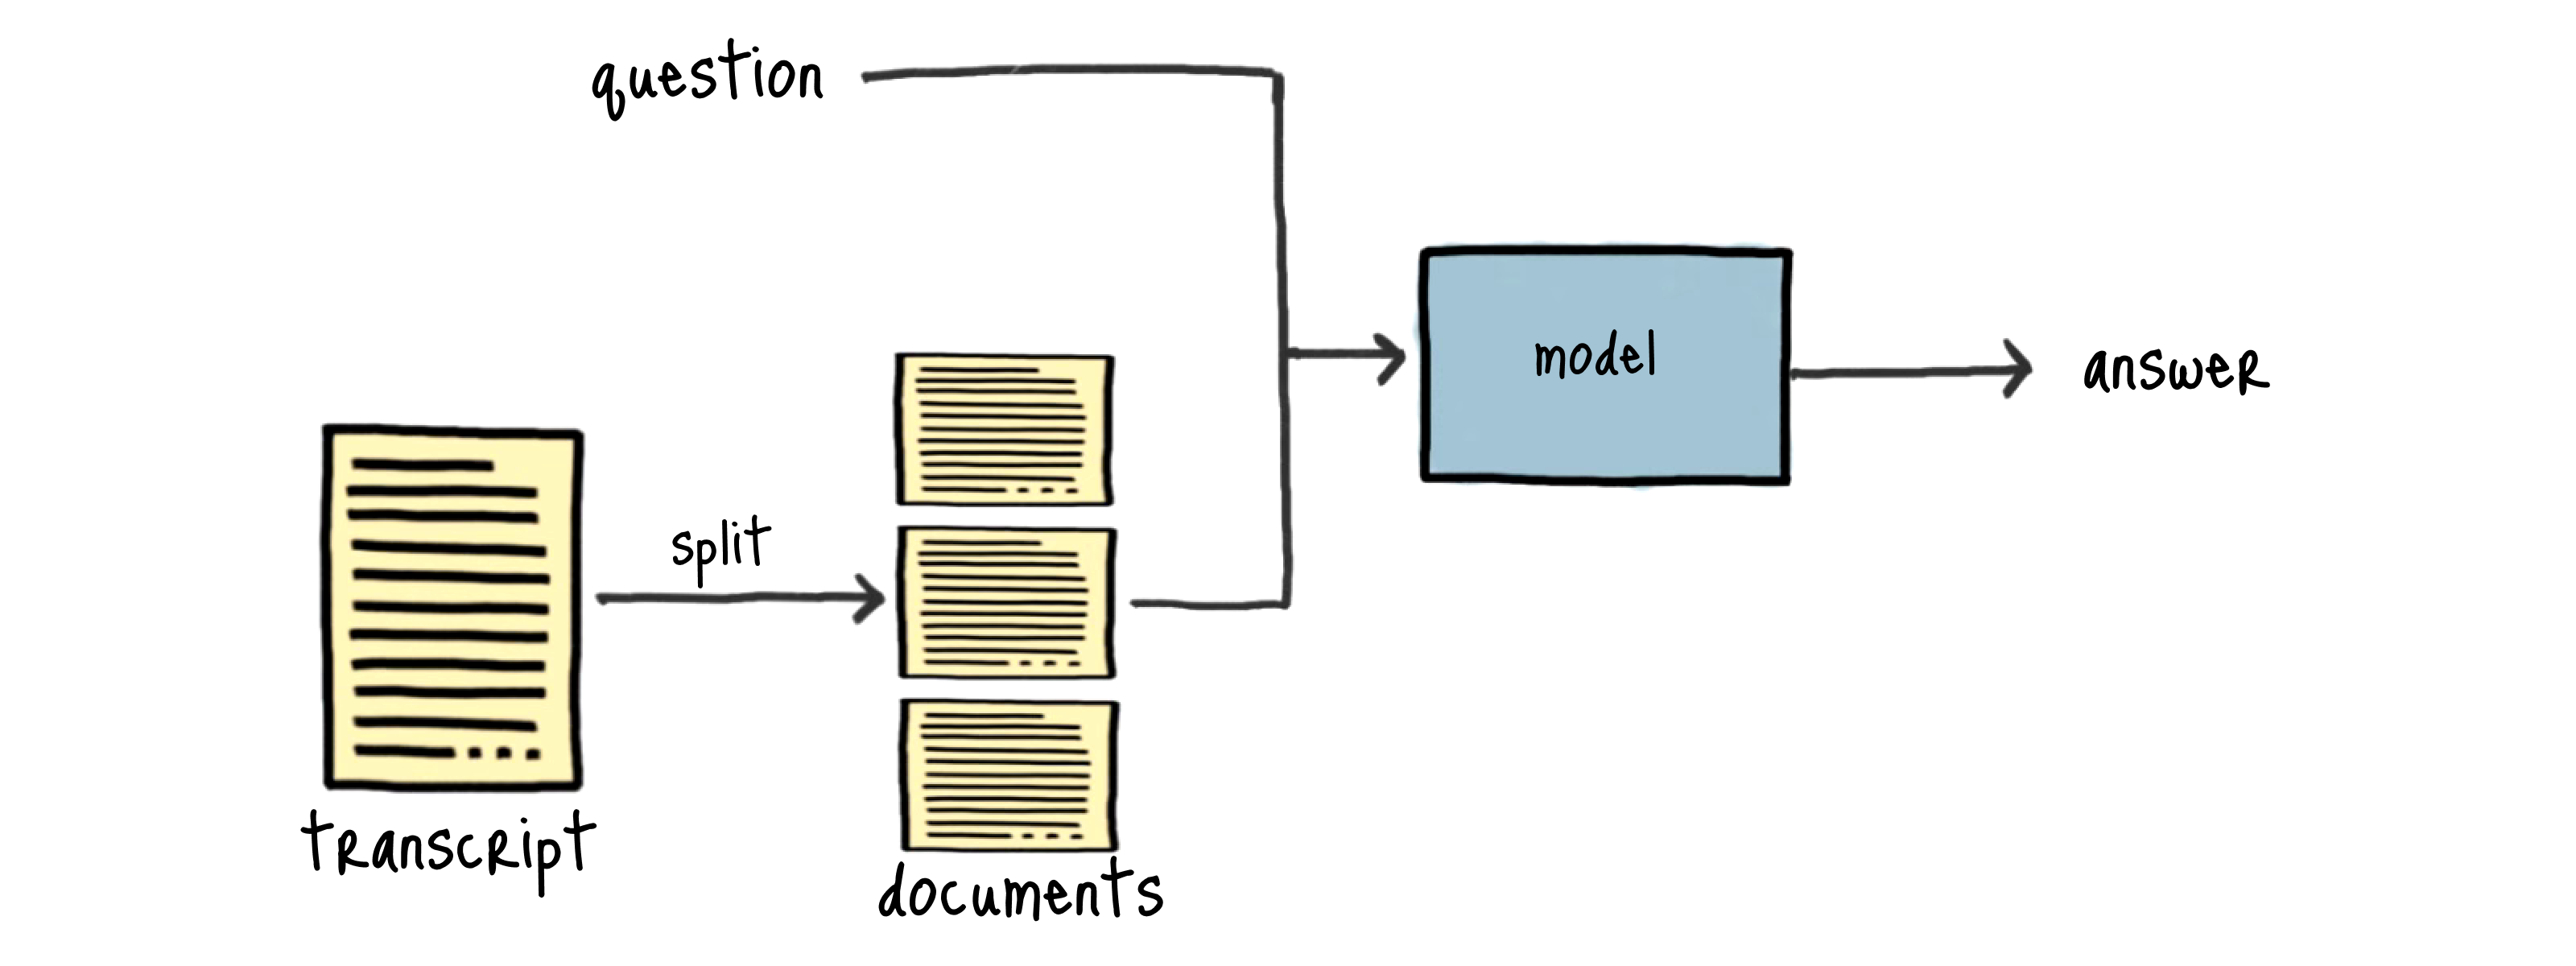

Let's start by loading the transcription in memory:

In [69]:
from langchain_community.document_loaders import TextLoader

In [78]:
loader = TextLoader("transcription.txt")

text_documents = loader.load()
# text_documents

We will split documents with `RecursiveCharacterTextSplitter`, defining, for each chunk:
- a size of 1 000,
- an overlap of 50.

In [72]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [76]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1_000, chunk_overlap=25)
documents = text_splitter.split_documents(text_documents)

In [77]:
documents[:3]

[Document(page_content="think it's possible that physics has exploits and we should be trying to find them arranging some kind of a crazy quantum mechanical system that somehow gives you buffer overflow somehow gives you a rounding error in the floating Point synthetic intelligences are kind of like the next stage of development and I don't know where it leads to like at some point I suspect the universe is some kind of a puzzle these synthetic AIS will uncover that puzzle and solve it the following is a conversation with Andre capothy previously the director of AI at Tesla and before that at open Ai and Stanford he is one of the greatest scientists engineers and Educators in the history of artificial intelligence this is the Lex Friedman podcast to support it please check out our sponsors and now dear friends here's Andre capathi what is a neural network and why does it seem to uh do such a surprisingly good job of learning what is a neural network it's a mathematical abstraction of t